Using parameters: {'beta': 0.31172069825436405, 'gamma': 0.15, 'mu': 0.1, 'N': 1.0, 'T': 12.0, 'lambda_decay': 0.03, 'target_fraction_users': 0.198}


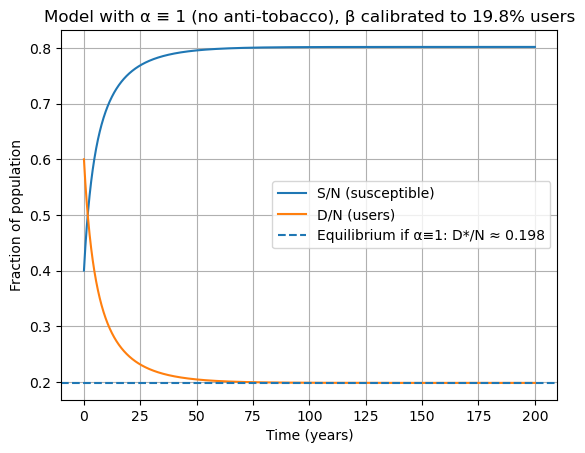

Using parameters: {'beta': 0.31172069825436405, 'gamma': 0.15, 'mu': 0.1, 'N': 1.0, 'T': 12.0, 'lambda_decay': 0.03, 'target_fraction_users': 0.198}


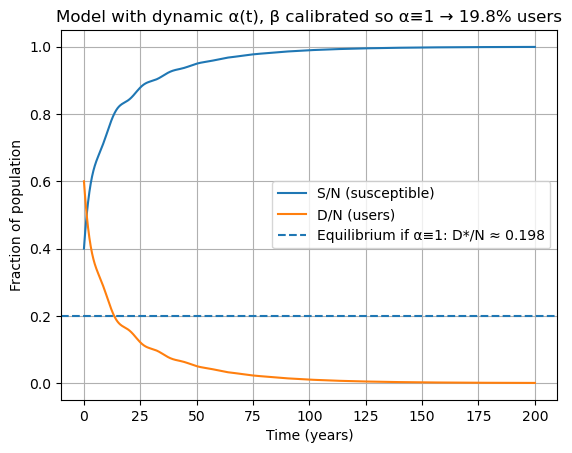

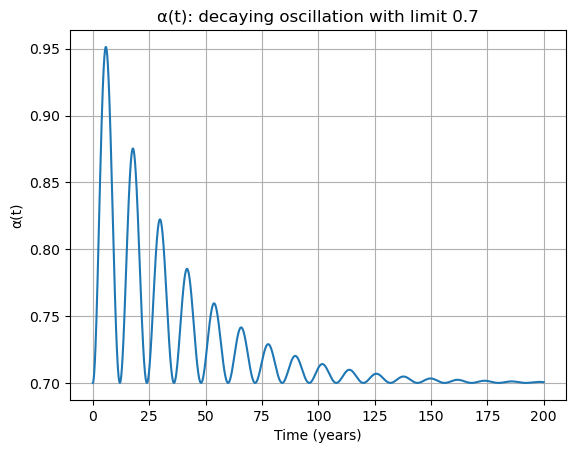

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# alpha(t): smooth, decaying oscillation with limit 0.7
# ------------------------------------------------------------
def alpha_t(t, T, lambda_decay):
    """
    alpha(t) = 0.7 + 0.3 * exp(-lambda_decay * t) * oscillation(t),
    where oscillation(t) is in [0, 1].

    - Early on: alpha(t) ~ [0.7, 1.0]
    - As t -> ∞: oscillations shrink and alpha(t) -> 0.7
    """
    oscillation = (1 - np.cos(2 * np.pi * t / T)) / 2  # in [0, 1]
    return 0.7 + 0.3 * np.exp(-lambda_decay * t) * oscillation


# ------------------------------------------------------------
# RHS of the 2-compartment addiction model (no delta)
# ------------------------------------------------------------
def rhs_addiction_SIS(t, y, p, use_constant_alpha1=False):
    S, D = y
    mu     = p["mu"]
    gamma  = p["gamma"]
    beta   = p["beta"]
    N      = p["N"]
    T      = p["T"]
    lambda_decay = p["lambda_decay"]

    if use_constant_alpha1:
        a = 1.0                # baseline: no anti-tobacco effect
    else:
        a = alpha_t(t, T, lambda_decay)

    # Your original structure with a(t) instead of constant alpha
    dSdt = mu * N - a * beta * S * D / N + gamma * D - mu * S
    dDdt = a * beta * S * D / N - gamma * D - mu * D

    return [dSdt, dDdt]


# ------------------------------------------------------------
# Choose parameters so that when alpha = 1, D*/N = target_fraction_users
# ------------------------------------------------------------
def make_params_calibrated_for_alpha1(gamma=0.15, mu=0.10,
                                      N=1.0, T=12.0,
                                      lambda_decay=0.03,
                                      target_fraction_users=0.198):
    """
    Calibrate beta using the constant-alpha=1 formula:

      D*/N = 1 - (gamma + mu)/beta

    so that D*/N = target_fraction_users when alpha = 1.
    """
    f = target_fraction_users
    beta = (gamma + mu) / (1.0 - f)

    return {
        "beta": beta,
        "gamma": gamma,
        "mu": mu,
        "N": N,
        "T": T,
        "lambda_decay": lambda_decay,
        "target_fraction_users": f,
    }


# ------------------------------------------------------------
# Simulation + plots
# ------------------------------------------------------------
def simulate_addiction_SIS(t_span=(0, 80), y0=(0.4, 0.6),
                           params=None,
                           use_constant_alpha1=False):
    if params is None:
        params = make_params_calibrated_for_alpha1()

    print("Using parameters:", params)

    sol = solve_ivp(
        lambda t, y: rhs_addiction_SIS(t, y, params, use_constant_alpha1),
        t_span,
        y0,
        dense_output=True,
        max_step=0.1
    )

    t = np.linspace(t_span[0], t_span[1], 2000)
    S, D = sol.sol(t)
    N = params["N"]

    beta  = params["beta"]
    gamma = params["gamma"]
    mu    = params["mu"]
    f_target = params["target_fraction_users"]

    # Theoretical equilibrium if alpha ≡ 1
    D_star_alpha1 = 1.0 - (gamma + mu) / beta

    plt.figure()
    plt.plot(t, S / N, label="S/N (susceptible)")
    plt.plot(t, D / N, label="D/N (users)")
    plt.axhline(D_star_alpha1, linestyle="--",
                label=f"Equilibrium if α≡1: D*/N ≈ {D_star_alpha1:.3f}")
    plt.xlabel("Time (years)")
    plt.ylabel("Fraction of population")
    if use_constant_alpha1:
        plt.title("Model with α ≡ 1 (no anti-tobacco), β calibrated to " \
        "19.8% users")
    else:
        plt.title("Model with dynamic α(t), β calibrated so α≡1 → 19.8% users")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot alpha(t) only when using dynamic alpha
    if not use_constant_alpha1:
        alpha_vals = alpha_t(t, params["T"], params["lambda_decay"])
        plt.figure()
        plt.plot(t, alpha_vals)
        plt.xlabel("Time (years)")
        plt.ylabel("α(t)")
        plt.title("α(t): decaying oscillation with limit 0.7")
        plt.grid(True)
        plt.show()

    return t, np.vstack((S, D))


# ------------------------------------------------------------
# Run tests
# ------------------------------------------------------------
if __name__ == "__main__":
    # 1) Sanity check: α ≡ 1 baseline should go to ~19.8% users
    simulate_addiction_SIS(t_span=(0, 200), y0=(0.4, 0.6),
                           use_constant_alpha1=True)

    # 2) Dynamic α(t): same β, now see 
    # long-term effect of anti-tobacco movement
    simulate_addiction_SIS(t_span=(0, 200), y0=(0.4, 0.6),
                           use_constant_alpha1=False)
